# A/B Test of Fast Food
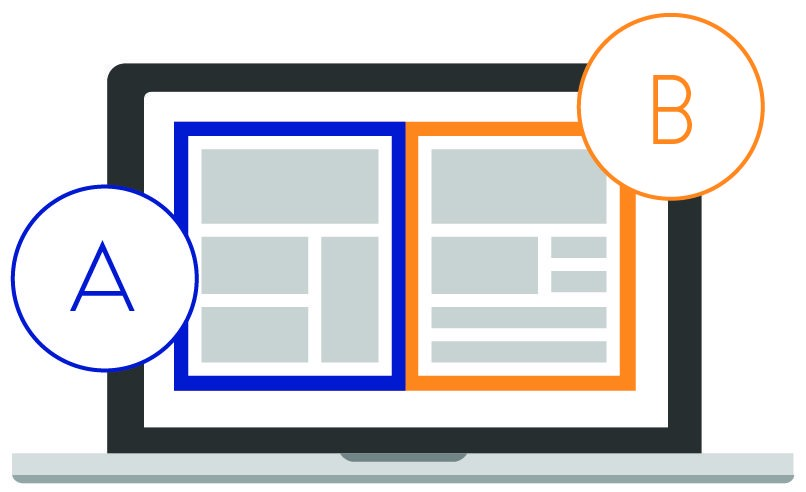
<p>A/B testing is a method for testing user reactions to a new feature or product, allowing decisions to be made based on data. The test splits users into a control group for which nothing changes (group 'A'), and a treatment group for which the new feature is presented (group 'B').</p>

<p>In marketing, A/B tests are used in areas such as:</p>
<ul>
<li>Improving website click rates with varying titles,</li>
<li>Improving retention rates in games,</li>
<li>Product recommendations on web pages,</li>
<li>Testing different descriptions of products.</li>
</ul>

## Table of Contents:
1. [Not so fast intro](#a)<br>
2. [The AB-test data](#b)<br>
3. [Hello, is there someone named Missing Value??](#c)<br>
4. [Promotion Sales](#d)<br>
5. [Market Size](#e)<br>
6. [Age of Store](#f)<br>
7. [Overall Sales](#g)<br>
8. [Sales by AB-group](#h)<br>
9. [Should we have confidence in differences?](#i)<br>
10. [Difference between Promotion one and Promotion three¶](#j)<br>
11. [The probability of a difference](#k)<br>
12. [Different differences](#l)<br>
13. [Normality Assumption #1: Levene's](#m)<br>
14. [Normality Assumption #2: Shapiro](#n)<br>
15. [Non-Parametric ANOVA](#o)<br>
16. [Post-Hoc Analysis](#p)<br>
17. [Conclusion](#q)<br>
<br>

<a id="a"></a>
## 1| Not so fast intro
<p>A fast-food chain plans to add a new item to its menu. However, the chain is still undecided between three possible marketing campaigns for promoting the new product. The new item is introduced at locations in several randomly selected markets to determine which promotion has the most significant effect on sales. A random promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks.</p>
<p>An essential step before undertaking any analysis is understanding the data. So let's load it in and take a look!</p>

In [363]:
# Importing pandas
import pandas as pd

# Reading in the data
df = pd.read_csv('WA_Marketing-Campaign.csv')

# Showing the first few rows
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


<a id="b"></a>
## 2| The AB-test data
<p>Our data has 548 observations of the AB-test. The variables are:</p>
<ul>
<li><code>MarketID</code> - a unique number that identifies each market.</li>
<li><code>MarketSize</code> - whether the market is small, medium, or large.</li>
<li><code>LocationID</code> - a unique number that identifies each location.</li>
<li><code>AgeOfStore</code> - how old the store is.</li>
<li><code>Promotion</code> - whether the store ran promotions <code>1</code>, <code>2</code>, or <code>3</code>.</li>
<li><code>week</code> - what week did the promotion run.</li>
<li><code>SalesInThousands</code> - how much sales were generated for the new item.</li>
</ul>
<p>When a location randomly participated, the location was randomly assigned to either promotion <code>1</code>, <code>2</code>, or <code>3</code>. As a sanity check, let's see if there are roughly the same number of promotions in each AB group. </p>

In [364]:
# DataFrame shape
print(df.shape)

# Total sample size
n_obs = len(df)

# Skip a line
print("\n")

# Count of unique locations that are in the sample
unique_loc = len(df['LocationID'].unique())
print("The number of locations participating is:",unique_loc)

# Skip a line
print("\n")

# Counting the number of promotion observations in each AB group.
print(df.groupby('Promotion').count())

# Skip a line
print("\n")

one = df.Promotion.value_counts()[1]
one_pct = (one/n_obs) * 100
print(one_pct, "%")

two = df.Promotion.value_counts()[2]
two_pct = (two/n_obs) * 100
print(two_pct, "%")

three = df.Promotion.value_counts()[3]
three_pct = (three/n_obs) * 100
print(three_pct, "%")

(548, 7)


The number of locations participating is: 137


           MarketID  MarketSize  LocationID  AgeOfStore  week  \
Promotion                                                       
1               172         172         172         172   172   
2               188         188         188         188   188   
3               188         188         188         188   188   

           SalesInThousands  
Promotion                    
1                       172  
2                       188  
3                       188  


31.386861313868614 %
34.306569343065696 %
34.306569343065696 %


<a id="c"></a>
## 3| Hello, is there someone named Missing Value??
<p>A quick glance at the data says no to the question of missing values, and a clean data set is the only data set in town. And we're off to visit promotion town!</p>

In [365]:
# Check for missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head()

,Total,Percent
MarketID,0,0.0
MarketSize,0,0.0
LocationID,0,0.0
AgeOfStore,0,0.0
Promotion,0,0.0


<a id="d"></a>
## 4| Promotion Sales
<p><img src="all-american-classic-hamburgers.jpg" style="width:200px; float:left"> </p>
<br>
<p>There is roughly the same number of promotions in each group, sweet! Promotions two and three are equal as well.</p>
<p>This analysis will focus on how the promotion affects weekly sales, so let's examine the sales distribution with a plot.</p>

Text(0.5, 1.0, 'Sales by Promotion Type')

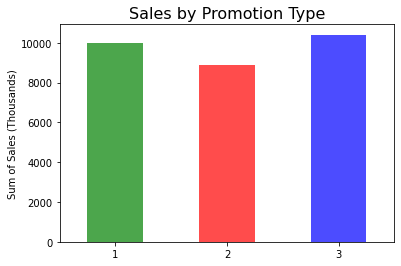

In [366]:
# This command makes plots appear in the notebook
%matplotlib inline

# Summing the sales for each type of promotion 
plot_df = df.groupby('Promotion')['SalesInThousands'].sum()

# Plotting the sales by promotion type
ax = plot_df.plot(x='Promotion',y='SalesInThousands',kind='bar', rot=0, color=['g', 'r', 'b'],alpha=0.7)
ax.set_xlabel("")
ax.set_ylabel("Sum of Sales (Thousands)")
ax.set_title("Sales by Promotion Type",fontsize=16)

<a id="e"></a>
## 5| Market Size
<p>In the plot above, we see promotion 3 has the most sales; however, all three have sold similarly.</p>
<p>We want customers to enjoy a promotion so much that they keep returning for the new item. A common metric in the restaurant industry for how successful a meal is <em>SalesInThousands</em>: The sales amount for the item in a <em>week</em>. 
<p>Let's move on to see the amount of the market size in each promotion.</p>

<AxesSubplot:>

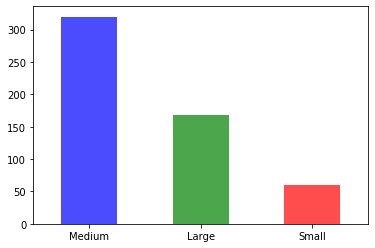

In [367]:
# Total of each market size
size = df['MarketSize'].value_counts()

# Bar graph plot of market size count
size.plot.bar(color=['b', 'g', 'r'],rot=0,alpha=0.7)

Text(0, 0.5, 'Count')

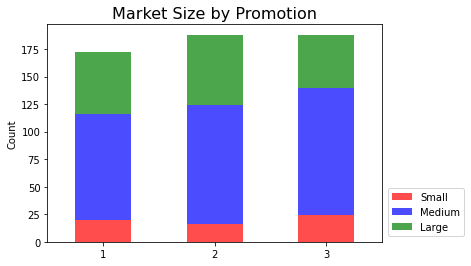

In [368]:
# Gather count of market size by promotions
m_size = df.groupby(['Promotion','MarketSize']).count().reset_index()

# Create pivot table of the data to be able to make stacked bar graph
pivot = pd.pivot_table(data=m_size, index=['Promotion'],columns=['MarketSize'],values='MarketID')

# Plotting the market size in each promotion type
ax = pivot[['Small','Medium','Large']].plot.bar(stacked=True, color =['r', 'b', 'g'],rot=0,alpha=0.7)
ax.set_title('Market Size by Promotion', fontsize=16)
ax.legend(bbox_to_anchor=(1.01, 0.02, 0.25, 0.25))
ax.set_xlabel("")
ax.set_ylabel("Count")

In [369]:
# Sales data by market size
df.groupby("MarketSize").agg({"SalesInThousands": ["count", "mean", "sum"]})

SalesInThousands                     
                      count       mean       sum
MarketSize                                      
Large                   168  70.116726  11779.61
Medium                  320  43.985344  14075.31
Small                    60  57.409333   3444.56

<a id="f"></a>
## 6| Age of Store
<p><img src="combo.png" style="width:200px; float:left"> </p>
<p>So, the small market size is represented only a little compared to medium and large, but a small market location outsells a medium market on average. Now that we have more information, let's look at how <code>AgeOfStore</code> differs between the AB groups.</p>
<p>Promotion three has the highest mean age of stores, and promotion two has the lowest.</p>
<p>A deeper look at the store ages distribution shows that many are new or less than five years old, and some stores are more than 20 years old.</p>

Promotion
1    8.279070
2    7.978723
3    9.234043
Name: AgeOfStore, dtype: float64


<AxesSubplot:title={'center':'Mean Age by Promotion Type'}, ylabel='Years'>

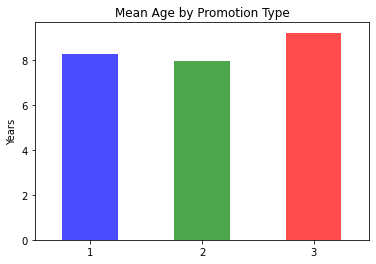

In [370]:
# Calculating the mean store ages for each AB-group
age = df.groupby('Promotion')['AgeOfStore'].mean()
print(age)

# Bar graph plot of Store Ages
age.plot.bar(color=['b', 'g', 'r'],rot=0,alpha=0.7,title='Mean Age by Promotion Type',xlabel="",ylabel="Years")

Text(0, 0.5, 'Count')

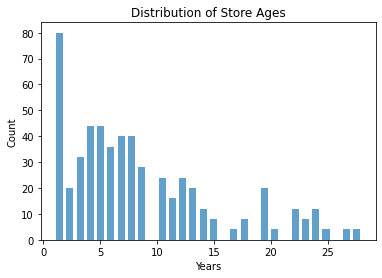

In [371]:
# Plot distribution of store age
ax = df['AgeOfStore'].hist(bins=30,grid=False,rwidth=0.7,alpha=0.7)
ax.set_title('Distribution of Store Ages')
ax.set_xlabel("Years",fontsize=10)
ax.set_ylabel("Count")

<a id="g"></a>
## 7| Overall Sales
<p>With the sample promotion groups' similar size, sales, and market sizes, we assume that the A/B test results can be meaningful.</p>
<p>First, let's look at what weekly sales is overall.</p>
<p></p>
<p></p>

In [372]:
# Calculating mean sales for all observations
meansales = df['SalesInThousands'].mean()
print("The mean sales in thousands is", meansales)

The mean sales in thousands is 53.46620437956205


<a id="h"></a>
## 8| Sales by AB-group
<p><img src="cart.jpg" style="width:200px; float:right"> </p>
<p>The average store's sales for the new item were about $53000. What are the mean sales by promotion type? Let's dig in!</p>

Promotion
1    58.099012
2    47.329415
3    55.364468
Name: SalesInThousands, dtype: float64


<AxesSubplot:title={'center':'Mean Sales by Promotion Type'}, ylabel='In Thousands'>

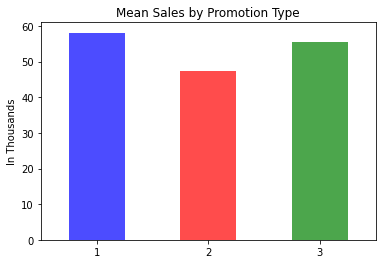

In [373]:
# Calculating mean sales by promotion type
meansales_type = df.groupby('Promotion')['SalesInThousands'].mean()
print(meansales_type)

# Plot the sales by promotion
meansales_type.plot.bar(color=['b', 'r', 'g'],rot=0,alpha=0.7,title='Mean Sales by Promotion Type',xlabel="",ylabel="In Thousands")

<a id="i"></a>
## 9| Should we have confidence in differences?
<p>Wow! Promotion three has the highest sum of sales, but it does not have the highest mean. That belongs to promotion one. Promotion one had fewer stores, which is why it did not have the highest sum.</p>
<p>Clearly, promotion two is the least successful. The difference between promotions one and three is not that large, but it can still impact them. While we are confident of the difference in the data, how certain should we be that promotion three will worsen in the future?</p>
<p>There are a couple of ways to get at these sales numbers' certainty. Here we will use bootstrapping: We will repeatedly re-sample our dataset (with replacement) and calculate sales for the samples. The variation in sales will give us an indication of how uncertain the numbers are.</p>

<AxesSubplot:ylabel='Density'>

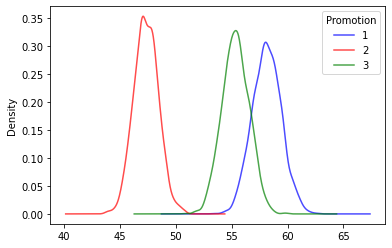

In [374]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(2000):
    boot_mean = df.sample(frac=1,replace=True).groupby('Promotion')\
    ['SalesInThousands'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(color=['b', 'r', 'g'],kind='kde',alpha=0.7)

<a id="j"></a>
## 10| Difference between Promotion one and Promotion three
<p>These three distributions above represent the bootstrap uncertainty over what the sales could be for the three AB groups. Just eyeballing this plot, we can see that there seems to be some evidence of a difference. Let's zoom in on the difference between promotions one and three.</p>
<p>(<em>Note that in this notebook, we have limited the number of bootstrap replication to 2000 to keep the calculations quick. In "production," we would likely increase this to a much larger number, say, 10000.</em>)</p>

Text(0.5, 0, '% Difference')

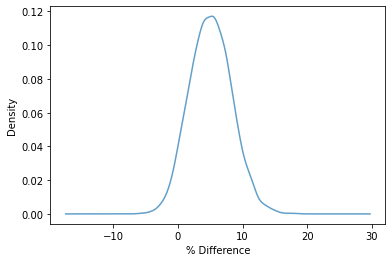

In [375]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = ((boot_1d[1] - boot_1d[3])\
/ boot_1d[3] * 100)

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind='kde',alpha=0.7)
ax.set_xlabel('% Difference')

<a id="k"></a>
## 11| The probability of a difference
<p><img src="healthy.png" style="width:200px; float:right"> </p>
<p>This chart shows that the most likely % difference is around 5% and that most of the distribution is above 0%, in favor of promotion one. But what is the <em>probability</em> that the difference is above 0%? Let's calculate that as well.</p>

In [376]:
# Calculating the probability that sales is greater when promotion one is used instead of promotion three
prob = ((boot_1d['diff'] > 0).sum() / len(boot_1d['diff']) )

# Pretty printing the probability
'{:.1%}'.format(prob)

'94.9%'

<a id="l"></a>
## 12| Different differences
<p>More evidence is better! We can examine the differences between promotions one and two, then the difference between promotions three and two. We want to be very confident that promotion one is best.</p>

Text(0.5, 0, '% Difference')

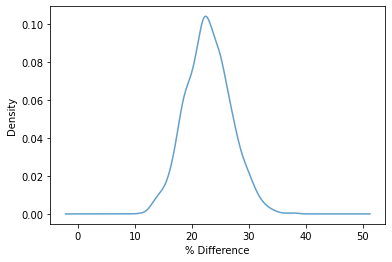

In [377]:
# Adding a column with the % difference between promotion one and two
boot_1d['diffone_two'] = ((boot_1d[1] - boot_1d[2])\
/ boot_1d[2] * 100)

# Ploting the bootstrap % difference
ax = boot_1d['diffone_two'].plot(kind='kde',alpha=0.7)
ax.set_xlabel('% Difference')

In [378]:
# Calculating the probability that sales is greater when promotion one is used instead of promotion two
probone_two = ((boot_1d['diffone_two'] > 0).sum() / len(boot_1d['diffone_two']) )

# Pretty printing the probability
'{:.1%}'.format(probone_two)

'100.0%'

Text(0.5, 0, '% Difference')

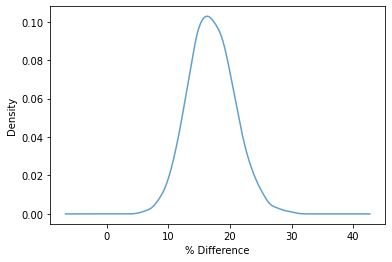

In [379]:
# Adding a column with the % difference between promotion three and two
boot_1d['diffthree_two'] = ((boot_1d[3] - boot_1d[2])\
/ boot_1d[2] * 100)

# Ploting the bootstrap % difference
ax = boot_1d['diffthree_two'].plot(kind='kde',alpha=0.7)
ax.set_xlabel('% Difference')

In [380]:
# Calculating the probability that sales is greater when promotion one is used instead of promotion two
probthree_two = ((boot_1d['diffthree_two'] > 0).sum() / len(boot_1d['diffthree_two']) )

# Pretty printing the probability
'{:.1%}'.format(probthree_two)

'100.0%'

<a id="m"></a>
## 13|  Normality Assumption #1: Levene's
<p><img src="Footlong.jpg" style="width:200px; float:left"> </p>
<p>A one-way ANOVA (Analysis of Variance) compares the means between the groups we are interested in and determines whether any of the means are statistically significantly different. It tests the null hypothesis:
    <br><br>
    $$ H_0: \mu_1 = \mu_2 = \mu_3 $$


where µ is the group mean. Suppose the one-way ANOVA returns a statistically significant result. In that case, we accept the alternative hypothesis, which is that at least two group means are statistically significantly different from each other.</p>
<p>To start, let's perform a variance homogeneity test. Levene's Test can determine if two or more groups have equal variances. The null hypothesis is that the population variances are equal.</p>
<p>We'll look at the standard deviations with normal vision and use Levene's Test to dissect further.</p>


In [381]:
# View standard deviations of the sales by promotion group
df.groupby('Promotion').agg({'SalesInThousands':'std'})

,SalesInThousands
Promotion,
1,16.553782
2,15.108955
3,16.766231


In [382]:
# Import Levene's test
from scipy.stats import levene

# Set alpha parameter
alpha = 0.05
    
def levenes_test(group1,group2,group3,center='median'):
    '''Given 3 groups, this function will determine whether two or more
    groups have equal variances.
    Arguments:
        group1: first group to be tested
        group2: second group to be tested
        group3: third group to be tested
    Returns:
        None''' 
    x,y = levene(group1,group2,group3,center=center)
    if y < alpha:
        print ("Statistics:", x, "p-value:", y)
        print("We reject the null hypothesis that the groups have equal variances.")
    else:
        print ("Statistics:", x, "p-value:", y)
        print("We cannot reject the null hypothesis that the groups have equal variances.")

# Call levenes_test with the median method
levenes_test(promotion_one, promotion_two, promotion_three)

# Skip a line
print("\n")
print("\n")

# Call levenes_test with the mean method
levenes_test(promotion_one, promotion_two, promotion_three,center='mean')

Statistics: 1.2696787527507418 p-value: 0.2817514565692118
We cannot reject the null hypothesis that the groups have equal variances.




Statistics: 2.159015566629321 p-value: 0.11642505194921923
We cannot reject the null hypothesis that the groups have equal variances.


<a id="n"></a>
## 14| Normality Assumption #2: Shapiro

<p>Variances of the promotion groups are equal, thanks to Levene's test. The Shapiro-Wilk test examines if a variable comes from a normal distribution. It was developed by Samuel Sanford Shapiro and Martin Wilk. The null hypothesis is that the sample comes from a normal distribution. A Shapiro-Wilk test in Python is performed by using the scipy.stats.shapiro() function. The function returns a test statistic and a p-value. Suppose the p-value is below an alpha of choice. In that case, we have evidence that the variable does not come from a normal distribution.</p>
<p>If p-values are above that, it means the normality assumption is satisfied. We can use ANOVA.</p>

In [383]:
# Create promotion types and overall promotions to test
overall_promotion = df['SalesInThousands']
promotion_one = df[df['Promotion'] == 1].loc[:,'SalesInThousands']
promotion_two = df[df['Promotion'] == 2].loc[:,'SalesInThousands']
promotion_three = df[df['Promotion'] == 3].loc[:,'SalesInThousands']

# Create a list of the promotion types
list_promotions = [promotion_one, promotion_two, promotion_three]

In [384]:
# Import Shapiro-Wilk test
from scipy.stats import shapiro

def shap_test(col):
    '''Given a list of columns, this function will check for a normal distribution 
    of each column using the Shapiro-Wilk test. It also gives an index for each column.
    Arguments:
        col: list containing columns to use for test
    Returns:
        None'''
    # Loop for checking columns
    for index,i in enumerate(col):
        #perform Shapiro-Wilk test
        a,b = shapiro(i)
        if b < alpha:
            print(f"Promotion #{index+1}")
            print ("Statistics", a, "p-value", b)
            print("We reject the null hypothesis that the data has a normal distribution.")
        else:
            print(f"Promotion #{index+1}")
            print ("Statistics", a, "p-value", b)
            print("We cannot reject the null hypothesis that the data has a normal distribution")

# Call shap_test for list 'list_promotions'         
shap_test(list_promotions)

Promotion #1
Statistics 0.9152998328208923 p-value 1.977244323825289e-08
We reject the null hypothesis that the data has a normal distribution.
Promotion #2
Statistics 0.9145088791847229 p-value 5.456262108793908e-09
We reject the null hypothesis that the data has a normal distribution.
Promotion #3
Statistics 0.9207685589790344 p-value 1.499518376135711e-08
We reject the null hypothesis that the data has a normal distribution.


In [385]:
def one_shap_test(col):
    '''Given a column, this function will check for a normal distribution 
    using the Shapiro-Wilk test.
    Arguments:
        col: column to use for test
    Returns:
        None'''
    #perform Shapiro-Wilk test
    a,b = shapiro(col)
    print ("Statistics", a, "p-value", b)
    if b < alpha:  
        print("We reject the null hypothesis that the data has a normal distribution.")
    else:
        print("We cannot reject the null hypothesis that the data has a normal distribution.")

# Call one_shap_test for overall_promotion column        
one_shap_test(overall_promotion)

Statistics 0.9346455335617065 p-value 9.384886192286522e-15
We reject the null hypothesis that the data has a normal distribution.


<a id="o"></a>
## 15|  Non-Parametric ANOVA
<p><img src="fish.jpg" style="width:200px; float:left"> </p>
<p>Well, all p-values for the promotions are below the alpha of 0.05. The variable <code>SalesInThousands</code> is not normal, which means no go on the normality assumption. We must move on to non-parametric methods to determine if the sales are statistically significant from each other. In comes Kruskal-Wallis's one-way analysis of variance.</p>
<p>Named after William Kruskal and W. Allen Wallis, the Kruskal-Wallis test measures if the samples originate from the same distribution. Very importantly, it does not assume a normal distribution. The null hypothesis is that the median is equal for all groups.</p>
<p></p>

In [386]:
# Import Kruskal-Wallis test
from scipy.stats import kruskal

def kruskal_test(group1,group2,group3):
    '''Given 3 groups, this function will determine whether the median
    is the same across the groups.
    Arguments:
        group1: first group to be tested
        group2: second group to be tested
        group3: third group to be tested
    Returns:
        None''' 
    k,r = kruskal(group1,group2,group3)
    if r < alpha:
        print ("Statistics:", k, "p-value:", r)
        print("We reject the null hypothesis that the median is equal across all groups.")
    else:
        print ("Statistics:", k, "p-value:", r)
        print("We cannot reject the null hypothesis that the median is equal across all groups.")

# Call kruskal_test
kruskal_test(promotion_one, promotion_two, promotion_three)

Statistics: 53.29475169322799 p-value: 2.6741866266697816e-12
We reject the null hypothesis that the median is equal across all groups.


<a id="p"></a>
## 16| Post-Hoc Analysis
<p>Promotions are having an effect on sales since the medians are statistically significant from each other.</p> 
<p>A Post-hoc test can determine if the difference between promotion one and promotion three will hold one more time. The Mann-Whitney U test is a non-parametric statistical significance test that looks if samples from a population have equal distributions. If the null hypothesis is rejected, then promotion one is what we recommend to the fast-food chain.</p>
<p></p>
<p></p>

In [387]:
# Import Mann-Whitney U test
from scipy.stats import mannwhitneyu
 
def mannwhitneyu_test(group1,group2):
    '''Given 2 groups, this function will determine whether the two 
    groups have equal distributions.
    Arguments:
        group1: first group to be tested
        group2: second group to be tested
    Returns:
        None''' 
    m,w = mannwhitneyu(group1,group2)
    if w < alpha:
        print ("Statistics:", m, "p-value:", w)
        print("We reject the null hypothesis that the groups have equal distributions.")
    else:
        print ("Statistics:", m, "p-value:", w)
        print("We cannot reject the null hypothesis that the groups have equal distributions.")

# Call mannwhitneyu_test
mannwhitneyu_test(promotion_one, promotion_three)

Statistics: 18247.0 p-value: 0.035084095693231204
We reject the null hypothesis that the groups have equal distributions.


<a id="q"></a>
## 17|  The conclusion
<p>The bootstrap result shows excellent evidence that sales are higher with <strong>promotion one</strong> compared to promotions two and three. The conclusion is: If we want to achieve high sales — SalesInThousands — we should <strong>not</strong> choose promotion two. There are, of course, other metrics we could look at, like the distance to the nearest chain location or total monthly sales of the location by the three AB groups. But SalesInThousands <em>is</em> one of the most critical metrics. If we don't sell enough of the new item, it is a missed opportunity for customers to spend more at our locations.</p>
<p><img src="drw.jpg" style="width:200px; float:center"> </p>
<p>For further evidence, normality tests told us that the sales were not normally distributed but did have equal variances. Non-parametric ANOVA analysis put a stamp on promotion one being statistically significant from the others. We don't know the specifics of what makes each promotion special. Otherwise, we would speculate why promotion one is doing better.</p>

In [388]:
# Given the data and the different tests used,
# which promotion should the fast food chain pursue?
chosen_promotion = "Promotion One" # Promotion 1, Promotion 2, or Promotion 3 ?
print(chosen_promotion)

Promotion One
